In [1]:
import sys
sys.path.insert(0, './yolov5')
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from IPython.display import display, Image
import ipywidgets.widgets as widgets
import warnings
warnings.filterwarnings(action='ignore')

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import colors, plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

# Load Model

In [2]:
set_logging()
device = torch.device('cuda')
weights = "best.pt"
imgsz = 640
# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(imgsz, s=stride)  # check img_size
names = model.module.names if hasattr(model, 'module') else model.names  # get class names

source = "0" #webcam
cudnn.benchmark = True  # set True to speed up constant image size inference
dataset = LoadStreams(source, img_size=imgsz, stride=stride)

model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
print("model load done")

Fusing layers... 
Model Summary: 224 layers, 7064698 parameters, 0 gradients


1/1: 0...  success (inf frames 640x480 at 30.00 FPS)

model load done


# Load Webcam

In [3]:
video = cv2.VideoCapture(0)
video.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
video.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

False

# Display

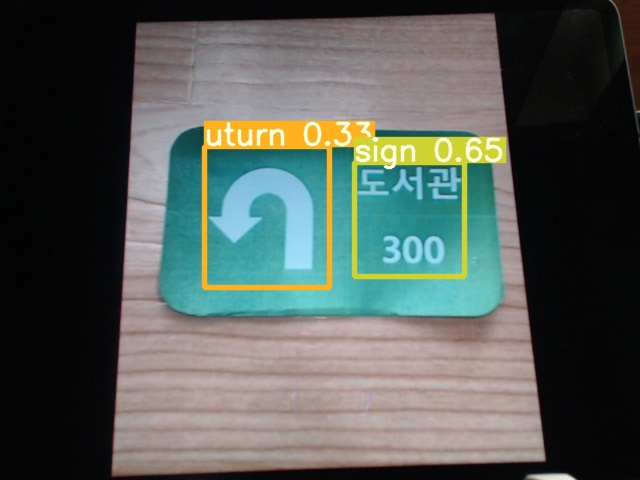

In [10]:
display_handle=display(None, display_id=True)

t0 = time.time()
try:
    for path, img, im0s, vid_cap in dataset:
        #_, img = video.read()
        img = torch.from_numpy(img).to(device)
        img = img.float()#img.half() #if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment='store_true')[0]

        # Apply NMS
        pred = non_max_suppression(pred, 0.3, 0.45, None, 'store_true',max_det=5)
        t2 = time_synchronized()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0, frame = path[i], f'{i}: ', im0s[i].copy(), dataset.count

            p = Path(p)  # to Path
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
                
                for *xyxy, conf, cls in reversed(det):
                    c = int(cls)  # integer class
                    label = f'{names[c]} {conf:.2f}'
                    plot_one_box(xyxy, im0, label=label, color=colors(c, True), line_thickness=3)

        # Stream results
        _, frame = cv2.imencode('.jpg', im0)
        display_handle.update(Image(data=frame.tostring()))
        cv2.waitKey(10)  # 1 millisecond
except KeyboardInterrupt:
    pass
finally:
    video.release()